## Gait Video Study 
### Traditional ML algorithms on task generalization framework 1: train on walking (W) and test on walking while talking (WT) to classify HOA/MS/PD strides and subjects 
#### Remember to add the original count of frames in a single stride (before down sampling via smoothing) for each stride as an additional artificial feature to add information about speed of the subject to the model

1. Save the optimal hyperparameters, confusion matrices and ROC curves for each algorithm.
2. Make sure to not use x, y, z, confidence = 0, 0, 0, 0 as points for the model since they are simply missing values and not data points, so make sure to treat them before inputting to model 
3. Make sure to normalize (mean substract) the features before we feed them to the model.
4. We use the summary statistics as range, CoV and asymmetry between the right and left limbs as the features to input to the traditional models requiring fixed size 1D input for each training/testing set sample.


In [14]:
# 33 subject in total (~10 per group) 
# 4500 strides - 2000 strides - 200 groups for 10 strides per group
# STRIDE - 20*36 - MEAN SUBSTRACTION --- BATCH NORM. 
# 90 features - 36 Cov, 36 Range, 18 assymetry, 18 DEN
# Z-SCORE 
# Default + Dimensionality reduction - 3D space
# Try top 10 features 
# Subject generalization is where the overfitting issue is tested - If we get good results, that means we are not 
# overfitting 

#Check how is AUC 1 even when accurcay is low?

In [15]:
from imports import *

In [16]:
path = 'C:\\Users\\Rachneet Kaur\\Box\\Gait Video Project\\GaitVideoData\\video\\'
data_path = path+'traditional_methods_dataframe.csv'
results_path = 'C:\\Users\\Rachneet Kaur\\Box\Gait Video Project\\MLresults\\'

data = pd.read_csv(data_path, index_col= 0)
display(data.head())

,key,cohort,trial,scenario,video,PID,stride_number,frame_count,label,right hip-x-CoV,...,ankle-z-asymmetry,heel-x-asymmetry,heel-y-asymmetry,heel-z-asymmetry,toe 1-x-asymmetry,toe 1-y-asymmetry,toe 1-z-asymmetry,toe 2-x-asymmetry,toe 2-y-asymmetry,toe 2-z-asymmetry
0,GVS_212_T_T1_1,HOA,BW,SLWT,GVS_212_T_T1,212,1,46,0,0.046077,...,14.426173,3.407379,10.662441,0.830365,0.502570,31.450487,8.644012,5.236678,31.182183,8.215725
1,GVS_212_T_T1_2,HOA,BW,SLWT,GVS_212_T_T1,212,2,39,0,0.021528,...,1.360847,5.155307,11.363806,4.333776,1.025647,28.266400,2.671081,6.678294,15.058825,4.903579
2,GVS_212_T_T1_3,HOA,BW,SLWT,GVS_212_T_T1,212,3,56,0,0.034394,...,1.341021,8.625363,7.159495,3.366152,1.759968,17.545787,5.921325,8.243491,9.578638,3.008162
3,GVS_212_T_T1_4,HOA,BW,SLWT,GVS_212_T_T1,212,4,53,0,0.028511,...,2.375934,6.728268,0.098235,0.999027,0.541911,7.843339,4.279617,0.748023,19.471731,5.086056
4,GVS_212_T_T1_5,HOA,BW,SLWT,GVS_212_T_T1,212,5,44,0,0.025213,...,8.525816,1.775282,0.033210,9.166863,1.354601,6.674183,8.479480,4.373622,0.315168,11.795593


### Utility functions 

In [17]:
def keep_subjects_common_across_train_test(trial_train, trial_test):
    '''
    Since we need to implement pure task generalization framework, we must have same subjects across both training and testing trails 
    Hence, if there are some subjects that are present in the training set but not in the test set or vice versa, we eliminate those 
    subjects to have only common subjects across training and test sets. 
    Arguments: data subset for training and testing trial
    Returns: training and testing subsets with common subjects 
    '''
    
    print ('Original number of subjects in training and test sets:', len(trial_train['PID'].unique()), len(trial_test['PID'].unique()))

    #Try to use same subjects in trials W and WT for testing on same subjects we train on
    print ('Subjects in test set, which are not in training set')
    pids_missing_training = [] #PIDs missing in training set (trial W) but are present in the test set (trial WT)
    for x in trial_test['PID'].unique():
        if x not in trial_train['PID'].unique():
            pids_missing_training.append(x)
    print (pids_missing_training)

    #Deleting the subjects from the test set that are missing in the training set 
    trial_test_reduced = trial_test.set_index('PID').drop(pids_missing_training).reset_index()

    print ('Subjects in training set, which are not in test set')
    pids_missing_test = [] #PIDs missing in test set (trial WT) but are present in the training set (trial W)
    for x in trial_train['PID'].unique():
        if x not in trial_test['PID'].unique():
            pids_missing_test.append(x)
    print (pids_missing_test)

    #Deleting the subjects from the training set that are missing in the test set 
    trial_train_reduced = trial_train.set_index('PID').drop(pids_missing_test).reset_index()

    print ('Number of subjects in training and test sets after reduction:', len(trial_train_reduced['PID'].unique()), \
           len(trial_test_reduced['PID'].unique()))
    #Returning the dataframes where the training and testing set have common subjects 
    return trial_train_reduced, trial_test_reduced 

In [18]:
#Standardize the data before ML methods 
#Take care that testing set is not used while normalizaing the training set, otherwise the train set indirectly contains 
#information about the test set
def normalize(dataframe, n_type): 
    '''
    Arguments: training set dataframe, type of normalization (z-score or min-max)
    Returns: Computed mean and standard deviation for the training set 
    '''
    col_names = list(dataframe.columns)
    if (n_type == 'z'): #z-score normalization 
        mean = dataframe.mean()
        sd = dataframe.std()
    else: #min-max normalization
        mean = dataframe.min()
        sd = dataframe.max()-dataframe.min()
    return mean, sd

In [19]:
def models(trainX, trainY, testX, testY, model_name = 'random_forest', framework = 'WtoWT'):
    '''
    Function to define and tune ML models 
    Arguments: training set: trainX, testX, testing set: testX, testY, model: model_name, framework
    Returns: Prediction probabilities for HOA/MS/PD and stride and subject wise evaluation metrics 
    (Accuracy, Precision, Recall, F1 and AUC)
    '''
    trainY1 = trainY['label'] #Dropping the PID
    
    if(model_name == 'random_forest'): #Random Forest
        grid = {
       'n_estimators': [40,45,50],\
       'max_depth' : [15,20,25,None],\
       'class_weight': [None, 'balanced'],\
       'max_features': ['auto','sqrt','log2', None],\
       'min_samples_leaf':[1,2,0.1,0.05]
        }
        rf_grid = RandomForestClassifier(random_state=0)
        grid_search = GridSearchCV(estimator = rf_grid, param_grid = grid, scoring='accuracy', n_jobs = 1, cv = 5)
    
    if(model_name == 'adaboost'): #Adaboost
        ada_grid = AdaBoostClassifier(random_state=0)
        grid = {
        'n_estimators':[50, 75, 100, 125, 150],\
        'learning_rate':[0.01,.1, 1, 1.5, 2]\
        }
        grid_search = GridSearchCV(ada_grid, param_grid = grid, scoring='accuracy', n_jobs = 1, cv=5)
    
    if(model_name == 'kernel_svm'): #RBF SVM
        svc_grid = SVC(kernel = 'rbf', probability=True, random_state=0)
        grid = {
        'gamma':[0.0001, 0.001, 0.1, 1, 10, ]\
        }
        grid_search = GridSearchCV(svc_grid, param_grid=grid, scoring='accuracy', n_jobs = 1, cv=5)

    if(model_name == 'gbm'): #GBM
        gbm_grid = GradientBoostingClassifier(random_state=0)
        grid = {
        'learning_rate':[0.15,0.1,0.05], \
        'n_estimators':[50, 100, 150],\
        'max_depth':[2,4,7],\
        'min_samples_split':[2,4], \
        'min_samples_leaf':[1,3],\
        'max_features':[4, 5, 6]\
        }
        grid_search = GridSearchCV(gbm_grid, param_grid=grid, scoring='accuracy', n_jobs = 1, cv=5)
    
    if(model_name=='xgboost'): #Xgboost
        xgb_grid = xgboost.XGBClassifier(random_state=0)
        grid = {
            'min_child_weight': [1, 5],\
            'gamma': [0.1, 0.5, 1, 1.5, 2],\
            'subsample': [0.6, 0.8, 1.0],\
            'colsample_bytree': [0.6, 0.8, 1.0],\
            'max_depth': [5, 7, 8]
        }
        grid_search = GridSearchCV(xgb_grid, param_grid=grid, scoring='accuracy', n_jobs = 1, cv=5)
    
    if(model_name == 'knn'): #KNN
        knn_grid = KNeighborsClassifier()
        grid = {
            'n_neighbors': [1, 3, 4, 5, 10],\
            'p': [1, 2, 3, 4, 5]\
        }
        grid_search = GridSearchCV(knn_grid, param_grid=grid, scoring='accuracy', n_jobs = 1, cv=5)
        
    if(model_name == 'decision_tree'): #Decision Tree
        dec_grid = DecisionTreeClassifier(random_state=0)
        grid = {
            'min_samples_split': range(2, 50),\
        }
        grid_search = GridSearchCV(dec_grid, param_grid=grid, scoring='accuracy', n_jobs = 1, cv=5)
    
    if(model_name == 'linear_svm'): #Linear SVM
        lsvm_grid = LinearSVC(random_state=0)
        grid = {
            'loss': ['hinge','squared_hinge'],\

        }
        grid_search = GridSearchCV(lsvm_grid, param_grid=grid, scoring='accuracy', n_jobs = 1, cv=5)
    
    if(model_name == 'logistic_regression'): #Logistic regression
        grid_search = LogisticRegression(random_state=0)
    
    if(model_name == 'mlp'):
        mlp_grid = MLPClassifier(activation='relu', solver='adam', learning_rate = 'adaptive', learning_rate_init=0.001,\
                                                        shuffle=False, max_iter = 500, random_state = 0)
        grid = {
            'hidden_layer_sizes': [(128, 8, 8, 128, 32), (50, 50, 50, 50, 50, 50, 150, 100, 10), 
                                  (50, 50, 50, 50, 50, 60, 30, 20, 50), (50, 50, 50, 50, 50, 150, 10, 60, 150),
                                  (50, 50, 50, 50, 50, 5, 50, 10, 5), (50, 50, 50, 50, 50, 5, 50, 150, 150),
                                  (50, 50, 50, 50, 50, 5, 30, 50, 20), (50, 50, 50, 50, 10, 150, 20, 20, 30),
                                  (50, 50, 50, 50, 30, 150, 100, 20, 100), (50, 50, 50, 50, 30, 5, 100, 20, 100),
                                  (50, 50, 50, 50, 60, 50, 50, 60, 60), (50, 50, 50, 50, 20, 50, 60, 20, 20),
                                  (50, 50, 50, 10, 50, 10, 150, 60, 150), (50, 50, 50, 10, 50, 150, 30, 150, 5),
                                  (50, 50, 50, 10, 50, 20, 150, 5, 10), (50, 50, 50, 10, 150, 50, 20, 20, 100), 
                                  (50, 50, 50, 30, 100, 5, 30, 150, 30), (50, 50, 50, 50, 100, 150, 100, 200), 
                                  (50, 50, 50, 5, 5, 100, 100, 150), (50, 50, 5, 50, 200, 100, 150, 5), 
                                  (50, 50, 5, 5, 200, 100, 50, 30), (50, 50, 5, 10, 5, 200, 200, 10), 
                                  (50, 50, 5, 30, 5, 5, 50, 10), (50, 50, 5, 200, 50, 5, 5, 50), 
                                  (50, 50,50, 5, 5, 100, 100, 150), (5, 5, 5, 5, 5, 100, 50, 5, 50, 50), 
                                  (5, 5, 5, 5, 5, 100, 20, 100, 30, 30), (5, 5, 5, 5, 5, 20, 20, 5, 30, 100), 
                                  (5, 5, 5, 5, 5, 20, 20, 100, 10, 10), (5, 5, 5, 5, 10, 10, 30, 50, 10, 10), 
                                  (5, 5, 5, 5, 10, 100, 30, 30, 30, 10), (5, 5, 5, 5, 10, 100, 50, 10, 50, 10), 
                                  (5, 5, 5, 5, 10, 100, 20, 100, 30, 5), (5, 5, 5, 5, 30, 5, 20, 30, 100, 50), 
                                  (5, 5, 5, 5, 30, 100, 20, 50, 20, 30), (5, 5, 5, 5, 50, 30, 5, 50, 10, 100), 
                                  (21, 21, 7, 84, 21, 84, 84), (21, 21, 5, 42, 42, 7, 42), (21, 84, 7, 7, 7, 84, 5), 
                                  (21, 7, 84, 5, 5, 21, 120), (42, 5, 21, 21, 21, 5, 120), (42, 5, 42, 84, 7, 120, 84), 
                                  (50, 100, 10, 5, 100, 25), (10, 10, 25, 50, 25, 5), (50, 50, 50, 50, 50, 20, 30, 100, 60)]

        }
        grid_search = GridSearchCV(mlp_grid, param_grid=grid, scoring='accuracy', n_jobs = 1, cv=5)
        
    grid_search.fit(trainX, trainY1) #Fitting on the training set to find the optimal hyperparameters 
#     print('best score: ', grid_search.best_score_)
#     print('best_params: ', grid_search.best_params_, grid_search.best_index_)
#     print('Mean cv accuracy on test set:', grid_search.cv_results_['mean_test_score'][grid_search.best_index_])
#     print('Standard deviation on test set:' , grid_search.cv_results_['std_test_score'][grid_search.best_index_])
#     print('Mean cv accuracy on train set:', grid_search.cv_results_['mean_train_score'][grid_search.best_index_])
#     print('Standard deviation on train set:', grid_search.cv_results_['std_train_score'][grid_search.best_index_])
#     print('Test set performance:\n')
    person_wise_prob_for_roc, stride_person_metrics = evaluate(grid_search, testX, testY, framework, model_name)
    return person_wise_prob_for_roc, stride_person_metrics

In [20]:
def evaluate(model, test_features, trueY, framework, model_name):
    '''
    Function to evaluate ML models and plot it's confusion matrix
    Input: model, test set, true test set labels, framework name, model name
    Computes the stride and subject wise test set evaluation metrics 
    Returns: Prediction probabilities for HOA/MS/PD and stride and subject wise evaluation metrics 
    (Accuracy, Precision, Recall, F1 and AUC)
    '''
    test_labels = trueY['label'] #Dropping the PID
#     print ('Test labels', test_labels)
    predictions = model.predict(test_features)
#     print ('Predictions', predictions)
    
    #Stride wise metrics 
    acc = accuracy_score(test_labels, predictions)
    #For multiclass predictions, we need to use marco/micro average
    p = precision_score(test_labels, predictions, average='macro')  
    r = recall_score(test_labels, predictions, average = 'macro')
    f1 = f1_score(test_labels, predictions, average= 'macro')
    
    try:
        prediction_prob = model.predict_proba(test_features) #Score of the class with greater label
#         print ('Prediction Probability', model.predict_proba(test_features))
        
    except:
        prediction_prob = model.best_estimator_._predict_proba_lr(test_features) #For linear SVM
#         print ('Prediction Probability', model.best_estimator_._predict_proba_lr(test_features))
    
    #For computing the AUC, we would need prediction probabilities for all the 3 classes 
    auc = roc_auc_score(test_labels, prediction_prob, multi_class = 'ovo', average= 'macro')
    print('Stride-based model performance: ', acc, p, r, f1, auc)
    
    #For computing person wise metrics 
    temp = copy.deepcopy(trueY) #True label for the stride 
    temp['pred'] = predictions #Predicted label for the stride 
    #Saving the stride wise true and predicted labels for calculating the stride wise confusion matrix for each model
    temp.to_csv(results_path+ framework + '\\stride_wise_predictions_' + str(model_name) + '_' + framework + '.csv')
    
    x = temp.groupby('PID')['pred'].value_counts().unstack()
    #Input for subject wise AUC is probabilities at columns [0, 1, 2]
    proportion_strides_correct = x.divide(x.sum(axis = 1), axis = 0).fillna(0) 
    proportion_strides_correct['True Label'] = trueY.groupby('PID').first()
    #Input for precision, recall and F1 score
    proportion_strides_correct['Predicted Label'] = proportion_strides_correct[[0, 1, 2]].idxmax(axis = 1) 
    #Saving the person wise true and predicted labels for calculating the subject wise confusion matrix for each model
    proportion_strides_correct.to_csv(results_path+ framework + '\\person_wise_predictions_' + \
                                      str(model_name) + '_' + framework + '.csv')
    try:
        print (model.best_estimator_)
    except:
        pass
    #Person wise metrics 
    person_acc = accuracy_score(proportion_strides_correct['True Label'], proportion_strides_correct['Predicted Label'])
    person_p = precision_score(proportion_strides_correct['True Label'], proportion_strides_correct['Predicted Label'], \
                               average = 'macro')
    person_r = recall_score(proportion_strides_correct['True Label'], proportion_strides_correct['Predicted Label'], \
                            average = 'macro')
    person_f1 = f1_score(proportion_strides_correct['True Label'], proportion_strides_correct['Predicted Label'], \
                         average = 'macro')
    person_auc = roc_auc_score(proportion_strides_correct['True Label'], proportion_strides_correct[[0, 1, 2]], \
                               multi_class = 'ovo', average= 'macro')
    print('Person-based model performance: ', person_acc, person_p, person_r, person_f1, person_auc)
      
    #Plotting and saving the subject wise confusion matrix 
    plt.figure()
    confusion_matrix = pd.crosstab(proportion_strides_correct['True Label'], proportion_strides_correct['Predicted Label'], \
                                   rownames=['Actual'], colnames=['Predicted'], margins = True)
    sns.heatmap(confusion_matrix, annot=True, cmap="YlGnBu")
    plt.savefig(results_path + framework+'\\CFmatrix_task_generalize_' + framework + '_'+ ml_model+ '.png', dpi = 350)
    plt.show()
    return proportion_strides_correct[[0, 1, 2]], [acc, p, r, f1, auc, person_acc, person_p, person_r, person_f1, person_auc] 

In [21]:
#Test set ROC curves for cohort prediction 
def plot_ROC(ml_models, testY, predicted_probs_person, framework):
    '''
    Function to plot the ROC curve for models given in ml_models list 
    Input: ml_models (name of models to plot the ROC for),  test_Y (true test set labels with PID), 
        predicted_probs_person (predicted test set probabilities for all 3 classes - HOA/MS/PD), framework (WtoWT / VBWtoVBWT)
    Plots and saves the ROC curve with individual class-wise plots and micro/macro average plots 
    '''
    n_classes = 3 #HOA/MS/PD
    cohort = ['HOA', 'MS', 'PD']
    ml_model_names = {'random_forest': 'RF', 'adaboost': 'Adaboost', 'kernel_svm': 'RBF SVM', 'gbm': 'GBM', \
                      'xgboost': 'Xgboost', 'knn': 'KNN', 'decision_tree': 'DT',  'linear_svm': 'LSVM', 
                 'logistic_regression': 'LR', 'mlp': 'MLP'}
    #PID-wise true labels 
    person_true_labels = testY.groupby('PID').first()
    #Binarizing/getting dummies for the true labels i.e. class 1 is represented as 0, 1, 0
    person_true_labels_binarize = pd.get_dummies(person_true_labels.values.reshape(1, -1)[0])  

    sns.despine(offset=0)
    linestyles = ['-', '-', '-', '-.', '--', '-', '--', '-', '--']
    colors = ['b', 'magenta', 'cyan', 'g',  'red', 'violet', 'lime', 'grey', 'pink']
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for idx, ml_model in enumerate(ml_models): #Plotting the ROCs for all models in ml_models list
        fig, axes = plt.subplots(1, 1, sharex=True, sharey = True, figsize=(6, 4.5))
        axes.plot([0, 1], [0, 1], linestyle='--', label='Majority (AUC = 0.5)', linewidth = 3, color = 'k')
        # person-based prediction probabilities for class 0: HOA, 1: MS, 2: PD
        model_probs = predicted_probs_person[[ml_model+'_HOA', ml_model+'_MS', ml_model+'_PD']]

        for i in range(n_classes): #For 3 classes 0, 1, 2
            fpr[i], tpr[i], _ = roc_curve(person_true_labels_binarize.iloc[:, i], model_probs.iloc[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i]) #Computing the AUC score for each class
            #Plotting the ROCs for the three classes separately
            axes.plot(fpr[i], tpr[i], label = cohort[i] +' ROC (AUC = '+ str(round(roc_auc[i], 3))
                +')', linewidth = 3, alpha = 0.8, linestyle = linestyles[i], color = colors[i]) 

        # Compute micro-average ROC curve and ROC area (AUC)
        fpr["micro"], tpr["micro"], _ = roc_curve(person_true_labels_binarize.values.ravel(), model_probs.values.ravel())
        #Micro average AUC of ROC value
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"]) 
        #Plotting the micro average ROC 
        axes.plot(fpr["micro"], tpr["micro"], label= 'micro average ROC (AUC = '+ str(round(roc_auc["micro"], 3))
                +')', linewidth = 3, alpha = 0.8, linestyle = linestyles[3], color = colors[3])

        #Compute the macro-average ROC curve and AUC value
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)])) # First aggregate all false positive rates
        mean_tpr = np.zeros_like(all_fpr) # Then interpolate all ROC curves at this points
        for i in range(n_classes):
            mean_tpr += interp(all_fpr, fpr[i], tpr[i])
        mean_tpr /= n_classes  # Finally average it and compute AUC
        fpr["macro"] = all_fpr
        tpr["macro"] = mean_tpr
        #Macro average AUC of ROC value 
        roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
        #Plotting the macro average AUC
        axes.plot(fpr["macro"], tpr["macro"], label= 'macro average ROC (AUC = '+ str(round(roc_auc["macro"], 3))
            +')', linewidth = 3, alpha = 0.8, linestyle = linestyles[4], color = colors[4])

        axes.set_ylabel('True Positive Rate')
        axes.set_title('Task generalization '+framework + ' '+ ml_model_names[ml_model])
        plt.legend()
        # axes[1].legend(loc='upper center', bbox_to_anchor=(1.27, 1), ncol=1)

        axes.set_xlabel('False Positive Rate')
        plt.tight_layout()
        plt.savefig(results_path + framework+'\\ROC_task_generalize_' + framework + '_'+ ml_model+ '.png', dpi = 350)
        plt.show()

### main() 

In [22]:
#Trial W for training 
trialW = data[data['scenario']=='W']
#Trial WT for testing 
trialWT = data[data['scenario']=='WT']

#Trial W and WT after making sure both training and testing sets have common subjects 
trialW_reduced, trialWT_reduced = keep_subjects_common_across_train_test(trialW, trialWT)
# print ('Number of subjects in training and test sets after reduction:', len(trialW_reduced['PID'].unique()), \
#            len(trialWT_reduced['PID'].unique()))

cols_to_drop = ['PID', 'key', 'cohort', 'trial', 'scenario', 'video', 'stride_number', 'label']
#Shuffling the training stride data
trialW_reduced = shuffle(trialW_reduced, random_state = 0)
trainX = trialW_reduced.drop(cols_to_drop, axis = 1)
trainY = trialW_reduced[['PID', 'label']]
print ('Training shape', trainX.shape, trainY.shape)

#Shuffling the testing stride data 
trialWT_reduced = shuffle(trialWT_reduced, random_state = 0)
testX = trialWT_reduced.drop(cols_to_drop, axis = 1)
testY = trialWT_reduced[['PID', 'label']] #PID to compute person based metrics later 
print ('Testing shape', testX.shape, testY.shape)

#Normalize according to z-score standardization
norm_mean, norm_sd = normalize(trainX, 'z')
trainX_norm = (trainX-norm_mean)/norm_sd
testX_norm = (testX-norm_mean)/norm_sd

#Total strides and imbalance of labels in the training and testing set
#Training set 
print('Strides in training set: ', len(trialW_reduced))
print ('HOA, MS and PD strides in training set:\n', trialW_reduced['cohort'].value_counts())

#Test Set
print('\nStrides in test set: ', len(trialWT_reduced)) 
print ('HOA, MS and PD strides in test set:\n', trialWT_reduced['cohort'].value_counts())
print ('Imbalance ratio (controls:MS:PD)= 1:X:Y\n', trialWT_reduced['cohort'].value_counts()/trialWT_reduced['cohort'].value_counts()['HOA'])

framework = 'WtoWT' #Defining the task generalization framework of interest

Original number of subjects in training and test sets: 32 26
Subjects in test set, which are not in training set
[403]
Subjects in training set, which are not in test set
[312, 102, 112, 113, 115, 123, 124]
Number of subjects in training and test sets after reduction: 25 25
Training shape (1128, 91) (1128, 2)
Testing shape (1142, 91) (1142, 2)
Strides in training set:  1128
HOA, MS and PD strides in training set:
 PD     453
MS     341
HOA    334
Name: cohort, dtype: int64

Strides in test set:  1142
HOA, MS and PD strides in test set:
 PD     459
HOA    351
MS     332
Name: cohort, dtype: int64
Imbalance ratio (controls:MS:PD)= 1:X:Y
 PD     1.307692
HOA    1.000000
MS     0.945869
Name: cohort, dtype: float64


In [23]:
trialW.groupby(['video']).count()

,key,cohort,trial,scenario,PID,stride_number,frame_count,label,right hip-x-CoV,right hip-y-CoV,...,ankle-z-asymmetry,heel-x-asymmetry,heel-y-asymmetry,heel-z-asymmetry,toe 1-x-asymmetry,toe 1-y-asymmetry,toe 1-z-asymmetry,toe 2-x-asymmetry,toe 2-y-asymmetry,toe 2-z-asymmetry
video,,,,,,,,,,,,,,,,,,,,,
GVS_102_W_T1,90,90,90,90,90,90,90,90,90,90,...,90,90,90,90,90,90,90,90,90,90
GVS_112_W_T1,95,95,95,95,95,95,95,95,95,95,...,95,95,95,95,95,95,95,95,95,95
GVS_113_W_T1,57,57,57,57,57,57,57,57,57,57,...,57,57,57,57,57,57,57,57,57,57
GVS_115_W_T1,52,52,52,52,52,52,52,52,52,52,...,52,52,52,52,52,52,52,52,52,52
GVS_123_W_T1,118,118,118,118,118,118,118,118,118,118,...,118,118,118,118,118,118,118,118,118,118
GVS_124_W_T1,63,63,63,63,63,63,63,63,63,63,...,63,63,63,63,63,63,63,63,63,63
GVS_212_W_T2,44,44,44,44,44,44,44,44,44,44,...,44,44,44,44,44,44,44,44,44,44
GVS_213_W_T1,43,43,43,43,43,43,43,43,43,43,...,43,43,43,43,43,43,43,43,43,43
GVS_214_W_T1,38,38,38,38,38,38,38,38,38,38,...,38,38,38,38,38,38,38,38,38,38


In [ ]:
ml_models = ['logistic_regression', 'random_forest', 'adaboost', 'kernel_svm', 'gbm', 'xgboost', 'knn', 'decision_tree',  \
             'linear_svm', 'mlp']
metrics = pd.DataFrame(columns = ml_models) #Dataframe to store accuracies for each ML model for raw data 

#For storing predicted probabilities for person (for all classes HOA/MS/PD) to show ROC curves 
predicted_probs_person = pd.DataFrame(columns = [ml_model + cohort for ml_model in ml_models for cohort in ['_HOA', '_MS', '_PD'] ]) 

logistic_regression


C:\Users\Rachneet Kaur\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Stride-based model performance:  0.7898423817863398 0.7851457094388344 0.7810243824300049 0.780240606863425 0.9194723515404934
Person-based model performance:  0.92 0.9333333333333332 0.9259259259259259 0.9212962962962964 1.0


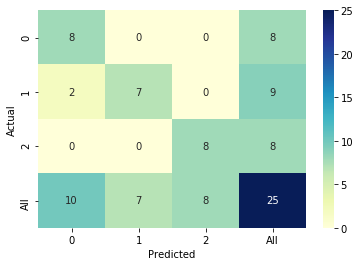

********************************
random_forest


In [ ]:
for ml_model in ml_models:
    print (ml_model)
    predict_probs_person, stride_person_metrics = models(trainX_norm, trainY, testX_norm, testY, ml_model, framework)  
    metrics[ml_model] = stride_person_metrics
    predicted_probs_person[ml_model+'_HOA'] = predict_probs_person[0]
    predicted_probs_person[ml_model+'_MS'] = predict_probs_person[1]
    predicted_probs_person[ml_model+'_PD'] = predict_probs_person[2]
    print ('********************************')

metrics.index = ['stride_accuracy', 'stride_precision', 'stride_recall', 'stride_F1', 'stride_AUC', 'person_accuracy', 
                     'person_precision', 'person_recall', 'person_F1', 'person_AUC']  
metrics.to_csv(results_path+ framework+ '\\task_generalize_'+framework+'_result_metrics.csv')
predicted_probs_person.to_csv(results_path +framework+ '\\task_generalize_'+framework+'_prediction_probs.csv')

In [ ]:
plot_ROC(ml_models, testY, predicted_probs_person, framework)

###  Task generalization framework 2: train on virtual beam walking (VBW) and test on virtual beam walking while talking (VBWT) with traditional ML algorithms to classify strides and subjects in HOA/MS/PD groups

In [ ]:
#Trial VBW for training 
trialVBW = data[data['scenario']=='SLW']
#Trial VBWT for testing 
trialVBWT = data[data['scenario']=='SLWT']

#Trial VBW and VBWT after making sure both training and testing sets have common subjects 
trialVBW_reduced, trialVBWT_reduced = keep_subjects_common_across_train_test(trialVBW, trialVBWT)
# print ('Number of subjects in training and test sets after reduction:', len(trialW_reduced['PID'].unique()), \
#            len(trialWT_reduced['PID'].unique()))

cols_to_drop = ['PID', 'key', 'cohort', 'trial', 'scenario', 'video', 'stride_number', 'label']
#Shuffling the training stride data
trialVBW_reduced = shuffle(trialVBW_reduced, random_state = 0)
trainX_VBW = trialVBW_reduced.drop(cols_to_drop, axis = 1)
trainY_VBW = trialVBW_reduced[['PID', 'label']]
print ('Training shape', trainX_VBW.shape, trainY_VBW.shape)

#Shuffling the testing stride data 
trialVBWT_reduced = shuffle(trialVBWT_reduced, random_state = 0)
testX_VBWT = trialVBWT_reduced.drop(cols_to_drop, axis = 1)
testY_VBWT = trialVBWT_reduced[['PID', 'label']] #PID to compute person based metrics later 
print ('Testing shape', testX_VBWT.shape, testY_VBWT.shape)

#Normalize according to z-score standardization
norm_mean_VB, norm_sd_VB = normalize(trainX_VBW, 'z')
trainX_norm_VBW = (trainX_VBW-norm_mean_VB)/norm_sd_VB
testX_norm_VBWT = (testX_VBWT-norm_mean_VB)/norm_sd_VB

#Total strides and imbalance of labels in the training and testing set
#Training set 
print('Strides in training set: ', len(trialVBW_reduced))
print ('HOA, MS and PD strides in training set:\n', trialVBW_reduced['cohort'].value_counts())

#Test Set
print('\nStrides in test set: ', len(trialVBWT_reduced)) 
print ('HOA, MS and PD strides in test set:\n', trialVBWT_reduced['cohort'].value_counts())
print ('Imbalance ratio (controls:MS:PD)= 1:X:Y\n', trialVBWT_reduced['cohort'].value_counts()/trialVBWT_reduced['cohort'].value_counts()['HOA'])

framework = 'VBWtoVBWT' #Defining the task generalization framework of interest

In [ ]:
ml_models = ['random_forest', 'adaboost', 'kernel_svm', 'gbm', 'xgboost', 'knn', 'decision_tree',  'linear_svm', 
             'logistic_regression', 'mlp']
metrics_VB = pd.DataFrame(columns = ml_models) #Dataframe to store accuracies for each ML model for raw data 
#For storing predicted probabilities for person (for classes HOA/MS/PD) to show ROC curves 
predicted_probs_person_VB = pd.DataFrame(columns = [ml_model + cohort for ml_model in ml_models for cohort in ['_HOA', '_MS', '_PD'] ]) 

In [ ]:
for ml_model in ml_models:
    print (ml_model)
    predict_probs_person_VB, stride_person_metrics_VB = models(trainX_norm_VBW, trainY_VBW, testX_norm_VBWT, testY_VBWT, ml_model, \
                                                              framework)
    metrics_VB[ml_model] = stride_person_metrics_VB
    predicted_probs_person_VB[ml_model+'_HOA'] = predict_probs_person_VB[0]
    predicted_probs_person_VB[ml_model+'_MS'] = predict_probs_person_VB[1]
    predicted_probs_person_VB[ml_model+'_PD'] = predict_probs_person_VB[2]
    print ('********************************')

metrics_VB.index = ['stride_accuracy', 'stride_precision', 'stride_recall', 'stride_F1', 'stride_AUC', 'person_accuracy', 
                     'person_precision', 'person_recall', 'person_F1', 'person_AUC']  
metrics_VB.to_csv(results_path+ framework+ '\\task_generalize_'+framework+'_result_metrics.csv')
predicted_probs_person_VB.to_csv(results_path+framework+'\\task_generalize_'+framework+'_prediction_probs.csv')

In [ ]:
metrics_VB

In [ ]:
#ROC 
plot_ROC(ml_models, testY_VBWT, predicted_probs_person_VB, framework)

In [ ]:
#Confusion matrices - Done
#micro/macro/weighted metric scores 
#Why is AUC 1 for low accuracy